#### Import data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Import training and test data

In [2]:
train_data = pd.read_csv('titanic/train.csv')
test_data = pd.read_csv('titanic/test.csv')

train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#### Clean & manipulate Data

In [3]:
exploration_data = train_data.copy()

exploration_data['Age'] = exploration_data['Age'].fillna(0)
exploration_data['Age'] = exploration_data['Age'].astype(int)
exploration_data = exploration_data.loc[exploration_data.Age != 0]
age = exploration_data.loc[exploration_data.Age != 0]['Age']

avg_age = sum(age)/len(age)
exploration_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C


#### Analyse Data

In [4]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### How many per class survived:

In [6]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


#### Family name as fname and title to train_data:

In [7]:
train_data = train_data.assign(fname = train_data.Name.str.split(",").str[0])
train_data["title"] = pd.Series([i.split(",")[1].split(".")[0].strip() for i in train_data.Name], index=train_data.index)
train_data.drop("Name", axis=1, inplace=True)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  fname        891 non-null    object 
 12  title        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [8]:
test_data = test_data.assign(fname = test_data.Name.str.split(",").str[0])
test_data["title"] = pd.Series([i.split(",")[1].split(".")[0].strip() for i in test_data.Name], index=test_data.index)
test_data.drop("Name", axis=1, inplace=True)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          332 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         417 non-null    float64
 8   Cabin        91 non-null     object 
 9   Embarked     418 non-null    object 
 10  fname        418 non-null    object 
 11  title        418 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


In [9]:
test_data.fname.nunique(), test_data.title.nunique()

(352, 9)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


['Master',
 'Master',
 'Don',
 'Master',
 'Master',
 'Master',
 'Master',
 'Master',
 'Master',
 'Rev',
 'Rev',
 'Master',
 'Master',
 'Master',
 'Master',
 'Master',
 'Master',
 'Master',
 'Master',
 'Dr',
 'Rev',
 'Master',
 'Master',
 'Master',
 'Dr',
 'Master',
 'Master',
 'Master',
 'Dr',
 'Master',
 'Master',
 'Major',
 'Master',
 'Master',
 'Major',
 'Master',
 'Lady',
 'Sir',
 'Rev',
 'Dr',
 'Col',
 'Dr',
 'Col',
 'Master',
 'Capt',
 'Master',
 'Master',
 'the Countess',
 'Dr',
 'Master',
 'Master',
 'Dr',
 'Master',
 'Master',
 'Master',
 'Jonkheer',
 'Master',
 'Master',
 'Master',
 'Rev',
 'Master',
 'Master',
 'Rev']

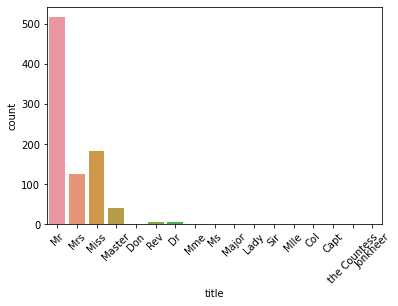

In [10]:
ts = sns.countplot(data=train_data, x="title")
ts = plt.setp(ts.get_xticklabels(), rotation=45)
print(train_data["title"].unique())
print(test_data["title"].unique())
other_titles = [title
                for title in train_data["title"]
                if title not in ["Mr", "Miss", "Mme", "Mlle", "Mrs", "Ms"]]
other_titles

#### Remove unneeded title and assign them numericals

In [11]:
def assign_numericals(title):
    if title == "Mr":
        numerical = 0
    elif title == "Ms" or "Miss" or "Mme" or "Mlle" or "Mrs":
        numerical = 1
    elif title == "Master":
        numerical = 2
    else:
        numerical = 3
    return numerical

train_data["title"] = train_data['title'].replace(other_titles, 'Other')
train_data["title"] = train_data["title"].map({"Mr":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Master":2, "Other":3})
test_data["title"] = test_data['title'].replace(other_titles, 'Other')
test_data["title"] = test_data["title"].map({"Mr":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Master":2, "Other":3})

train_data["title"]

0      0
1      1
2      1
3      1
4      0
      ..
886    3
887    1
888    1
889    0
890    0
Name: title, Length: 891, dtype: int64

#### Family name as survival assumption

In [12]:
# train_data = train_data.dropna(how='all')
age = train_data['Age']

avg_age = sum(age)/len(age)
age

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [13]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]

rate_women = sum(women)/len(women)

print(f"The rate of women is: {rate_women}")

The rate of women is: 0.7420382165605095


In [14]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print(f"The rate of men is: {rate_men}")
men

The rate of men is: 0.18890814558058924


0      0
4      0
5      0
6      0
7      0
      ..
883    0
884    0
886    0
889    1
890    0
Name: Survived, Length: 577, dtype: int64

In [25]:
from sklearn.ensemble import RandomForestClassifier


y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('result.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
